# 🌿 Plant Pathogen Classification with Deep Learning (InceptionV3) 🔍
## Introduction
Welcome to this notebook where we'll dive into the classification of plant images afflicted with various diseases using deep learning techniques, specifically leveraging the power of the InceptionV3 architecture. Accurate identification and monitoring of plant diseases are pivotal for ensuring agricultural productivity and food security. By harnessing the capabilities of deep learning models, we aim to automate the process of disease identification, enabling timely interventions to mitigate crop losses.

🌱🔬📊

In [1]:
# Imports
import os
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

2024-04-30 18:37:02.533062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 18:37:02.533115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 18:37:02.534536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Initial Data Exploration 🌱🔍

Before anything, let's explore the initial characteristics of our dataset. In this section, we'll perform the following tasks:

### Directory Structure 📂
We'll examine the directory structure of our dataset to understand how images are organized into classes.

### DataFrame Creation 🔬
We'll create a DataFrame containing image paths and corresponding class labels. This DataFrame will serve as the foundation for our data pipeline.

By conducting these initial explorations, we'll gain insights into the structure of our dataset, which will inform our subsequent steps in model training and evaluation.

In [2]:
# Directory where the imagenes are located
base_dir = '/kaggle/input/pathogen-dataset/pathogen'

# Get list of directories (classes)
classes = os.listdir(base_dir)

print('Classes in the dataset:', classes)

Classes in the dataset: ['Bacteria', 'Healthy', 'Fungi', 'Virus', 'Pests']


In [3]:
def create_dataframe(base_dir, classes):
    """
    Create a pandas DataFrame from image data stored in directories.

    Parameters:
    - base_dir (str): The base directory containing subdirectories for each class of images.
    - classes (str): The directory containing the classes of images within the base directory.

    Returns:
    - pandas.DataFrame: DataFrame containing image paths and corresponding class labels.

    Example:
    >>> df = create_dataframe('/path/to/base_directory', 'class_directory')
    """
    data = []

    for label in classes:
        class_dir = os.path.join(base_dir, label)
        for image in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image)
            relative_path = os.path.relpath(image_path, base_dir)
            data.append({"path": relative_path, "class": label})

    df = pd.DataFrame(data)
    return df

# Create dataframe with dataset information
df = create_dataframe(base_dir, classes)

print(df.head())
print(df.tail())

                                                path     class
0          Bacteria/enhanced_enhanced_image_1337.jpg  Bacteria
1                             Bacteria/image_747.jpg  Bacteria
2           Bacteria/enhanced_enhanced_image_966.jpg  Bacteria
3  Bacteria/Bacteria_original_image_1159.jpg_753a...  Bacteria
4  Bacteria/Bacteria_original_image_814.jpg_91e5e...  Bacteria
                                                    path  class
39992                      Pests/enhanced_image_1003.jpg  Pests
39993  Pests/Pests_original_enhanced_image_1485.jpg_d...  Pests
39994  Pests/Pests_original_enhanced_image_1740.jpg_2...  Pests
39995                               Pests/image_2577.jpg  Pests
39996  Pests/Pests_original_image_2080.jpg_f7d67faf-1...  Pests


## Data Analysis 🔍

Before diving into model training, it's crucial to analyze our dataset to gain insights into the nature of our data. In this section, we perform the following analyses:

### Display Dataset Images 🖼️
We visualize a subset of images from each class in our dataset to get a visual understanding of the data distribution and the types of pathogens present.

### Image Distribution 📊
We plot the distribution of images per class to understand the class balance and identify potential class imbalances.

### Image Sizes 🖼️
We examine the sizes of images in our dataset to determine the resolution we'll be working with. This information is essential for preprocessing and resizing the images before feeding them into the model.

By conducting these analyses, we gain valuable insights that will inform our approach to model training and evaluation.


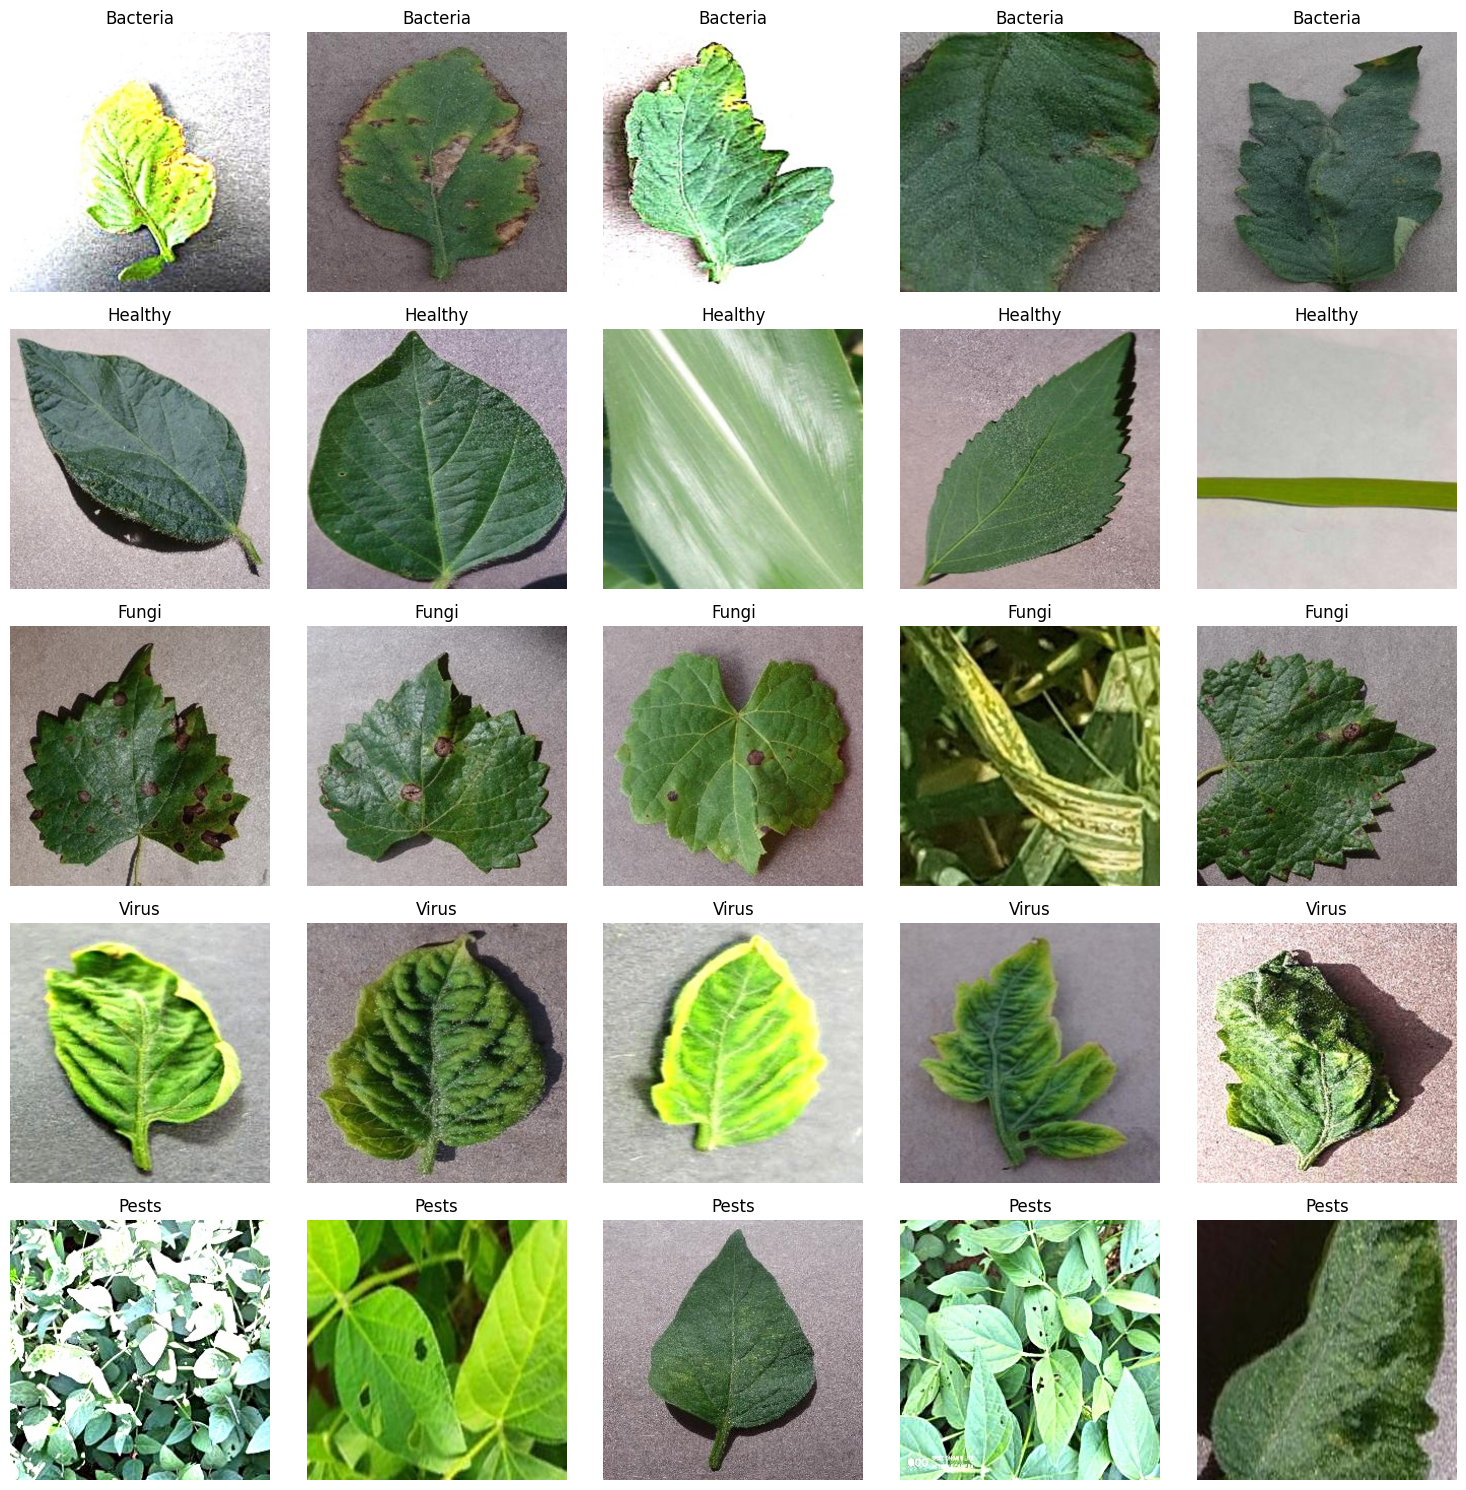

In [4]:
def display_dataset_images(df, base_dir, num_images_per_class=5):
    """
    Display the specified number of images per class in rows.

    Args:
    - df (pandas.DataFrame): DataFrame containing image paths and corresponding class labels.
    - base_dir (str): The base directory containing the image files.
    - num_images_per_class (int): Number of images to display per class. Default is 5.
    """
    # Get the unique class labels from the DataFrame
    classes = df['class'].unique()

    # Create a new figure
    plt.figure(figsize=(15, 3 * len(classes)))

    # Iterate over each class
    for i, class_name in enumerate(classes, 1):
        # Filter DataFrame to get only images for the current class
        class_df = df[df['class'] == class_name]
        # Take only the first N images for display
        class_images = class_df.head(num_images_per_class)

        # Iterate over the images in the current class
        for j, (_, row) in enumerate(class_images.iterrows(), 1):
            plt.subplot(len(classes), num_images_per_class, (i-1) * num_images_per_class + j)
            image_path = os.path.join(base_dir, row['path'])
            with Image.open(image_path) as img:
                plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)

    # Adjust layout to prevent overlapping titles
    plt.tight_layout()
    plt.show()
    
# Display the first five images for all pathogens in the dataset
display_dataset_images(df, base_dir, num_images_per_class=5)

## Image Distribution 📊

One of the critical aspects of dataset analysis is understanding the distribution of images across different classes. In our dataset, we have the luxury of having a perfectly balanced distribution, with an equal number of images for each class. This balance ensures that our model is exposed to an adequate representation of each class during training, preventing bias towards any particular class.

### Importance of Balanced Classes

Having balanced classes is crucial for the following reasons:

- **Improved Model Performance:** Balanced classes help prevent the model from being biased towards the majority class, leading to more accurate predictions across all classes.
  
- **Fair Evaluation:** Balanced classes ensure that the model's performance is not inflated due to imbalanced class distributions, allowing for a fair evaluation of its effectiveness.

- **Robustness:** Models trained on balanced datasets tend to be more robust and generalize better to unseen data, as they have learned to distinguish between all classes equally well.

In our dataset, the balanced distribution of images sets a solid foundation for training a reliable and effective model for plant pathogen classification.

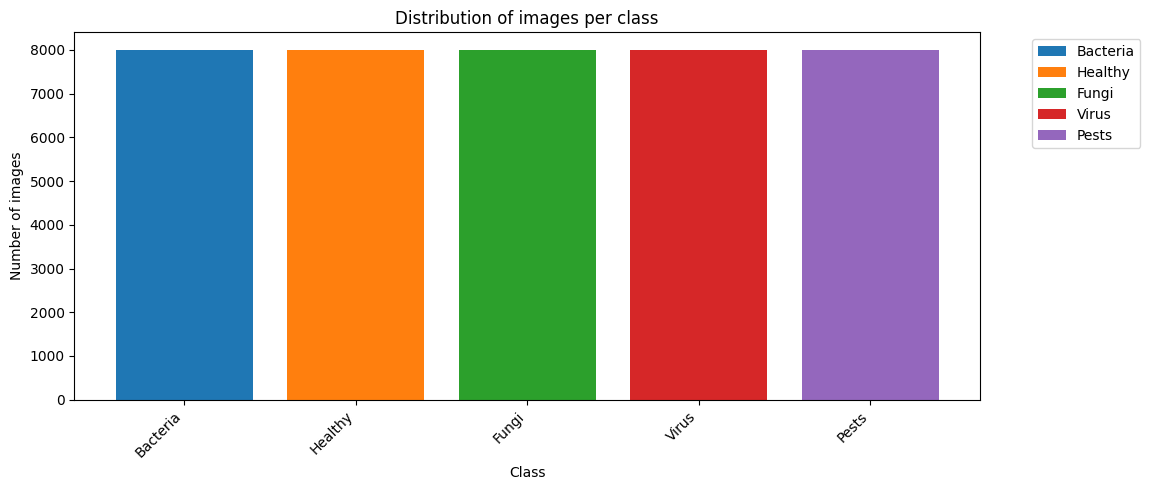

In [5]:
def plot_image_distribution(df):
    """
    Plot the distribution of images per class.

    Args:
    - df (pandas.DataFrame): DataFrame containing image paths and corresponding class labels.
    """
    # Counter to store the number of images per class
    class_counts = {}

    # Count the number of images per class
    for class_name in df['class'].unique():
        num_images = len(df[df['class'] == class_name])
        class_counts[class_name] = num_images

    # Create a colormap with a unique color for each class
    cmap = cm.tab10

    # Create the histogram with distinct colors for each class
    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color=cmap(range(len(class_counts))))
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Distribution of images per class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add a legend to show class names outside the plot to the right
    plt.legend(bars, class_counts.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    
# Plot the distribution of images per class
plot_image_distribution(df)

In [6]:
def get_image_sizes_per_directory(df, base_dir):
    """
    Get the sizes of images per directory.

    Args:
    - df (pandas.DataFrame): DataFrame containing image paths and corresponding class labels.
    - base_dir (str): The base directory containing the image files.
    """
    # Dictionary to store image sizes per directory
    sizes_per_directory = defaultdict(lambda: defaultdict(int))

    # Iterate through each row of the DataFrame
    for _, row in df.iterrows():
        class_name = row['class']
        image_path = os.path.join(base_dir, row['path'])
        with Image.open(image_path) as img:
            width, height = img.size
            # Update the count of image size in the directory
            sizes_per_directory[class_name][(width, height)] += 1

    # Print the sizes of images per directory
    for class_name, sizes in sizes_per_directory.items():
        print(f"{class_name}:")
        for size, count in sizes.items():
            print(f"Size: {size} -> {count}")
            
            
# Call the function with the DataFrame
get_image_sizes_per_directory(df, base_dir)

Bacteria:
Size: (512, 512) -> 7999
Healthy:
Size: (512, 512) -> 8000
Fungi:
Size: (512, 512) -> 8000
Virus:
Size: (512, 512) -> 7999
Pests:
Size: (256, 256) -> 7999


## Image Size Discrepancy 🖼️📏

During our initial data exploration, we encountered a discrepancy in the sizes of the images within our dataset. While most images are of size 512x512 pixels, some images have a smaller size of 256x256 pixels. This variation in image sizes could potentially pose challenges during model training, as the model may struggle to learn patterns effectively across images of different resolutions.

To address this issue and ensure uniformity in input size for our model, we'll preprocess the images using an `ImageDataGenerator`. We'll specify a target size of 512x512 pixels and use bicubic interpolation for resizing the images.

### Why Bicubic Interpolation?

Bicubic interpolation is a popular method for resizing images due to its ability to produce smoother results compared to other interpolation techniques. It preserves fine details and reduces aliasing artifacts, making it particularly suitable for upscaling images while maintaining visual quality. By using bicubic interpolation, we aim to ensure that the resized images retain as much information as possible, facilitating better model performance during training.


## Data Partitioning and Data Generators 📊🔧

In this section, we split our dataset into training, validation, and test sets according to the 70-10-20 rule, with 70% of the data for training, 10% for validation, and 20% for testing. Additionally, we define data generators for each set to facilitate data loading and preprocessing during model training.

### Data Partitioning
We partition our dataset as follows:
- **Training Set:** 70% of the original dataset.
- **Validation Set:** 10% of the original dataset.
- **Test Set:** 20% of the original dataset.

### Data Generators
We utilize Keras' `ImageDataGenerator` to generate batches of data for training, validation, and testing. The data generators perform real-time data augmentation and preprocessing, including resizing the images to a target size of 512x512 pixels using bicubic interpolation.

### Image Normalization
It's important to note that image normalization, such as centering the pixel values around zero, will not be performed at this stage. Instead, normalization will be integrated as a preprocessing layer within the model architecture. This approach allows for more flexibility in the normalization process and ensures consistency during both training and inference.

By splitting our dataset and defining data generators, we ensure proper handling of the data and prepare it for feeding into our InceptionV3 model, which requires images to be centered around zero.



In [7]:
# Separate data into features and labels
X = df['path']
y = df['class']

# Split original dataset into train and temp sets (80% train, 20% temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of train, validation, and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (31997,) (31997,)
Test set shape: (8000,) (8000,)


In [8]:
# Define data generator
datagen = ImageDataGenerator(validation_split=0.125)

# Define batch size
batch_size = 32

#Target size
target_size=(512, 512)

# Define data generator for train set
train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'path': X_train, 'class': y_train}),
    directory=base_dir,
    x_col='path',
    y_col='class',
    subset="training",
    target_size=target_size,
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    interpolation='bicubic'
)

# Define data generator for validation set
validation_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'path': X_train, 'class': y_train}),
    directory=base_dir,
    x_col='path',
    y_col='class',
    subset="validation",
    target_size=target_size, 
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    interpolation='bicubic'
)

test_datagen=ImageDataGenerator()
# Define data generator for test set
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'path': X_test, 'class': y_test}),
    directory=base_dir,
    x_col='path',
    y_col='class',
    target_size=target_size, 
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    interpolation='bicubic'    
)

Found 27998 validated image filenames belonging to 5 classes.
Found 3999 validated image filenames belonging to 5 classes.
Found 8000 validated image filenames belonging to 5 classes.


## Model Creation 🧠🔧

In this section, we create our deep learning model for classifying plant pathogens using the InceptionV3 architecture.

### Model Architecture
- **Input Layer:** Accepts input images with a shape of (512, 512, 3).
- **Rescaling Layer:** Normalizes pixel values to center them around zero.
- **Base Model (InceptionV3):** Utilizes the pre-trained InceptionV3 model with weights pretrained on ImageNet. The base model's layers are frozen to prevent them from being trained.
- **Global Average Pooling Layer:** Reduces the spatial dimensions of the feature map to a vector by taking the average of all feature maps.
- **Fully Connected Layer:** Consists of 1024 units with ReLU activation to learn complex patterns from the extracted features.
- **Dropout Layer:** Regularization technique to reduce overfitting by randomly dropping a fraction of input units.
- **Output Layer:** Produces the final predictions with softmax activation for multiclass classification.

### Compilation
The model is compiled with the Adam optimizer, categorical crossentropy loss function, and evaluation metrics including accuracy, precision, and recall.

By leveraging the InceptionV3 architecture and pretrained weights, we aim to build a robust and efficient model for plant pathogen classification.


In [9]:
# Set seed for reproducibility
tf.random.set_seed(42)

# Define input layer
inputs = Input((512, 512, 3))

# Define rescaling layer to normalize pixel values
scale_layer = Rescaling(scale=1.0 / 127.5, offset=-1)

# Apply rescaling to input
x = scale_layer(inputs)

# Load InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze the pre-trained layers to prevent them from being trained
base_model.trainable = False

# Pass the input through the base model
x = base_model(x)

# Global average pooling layer
x = GlobalAveragePooling2D()(x)

# Fully connected layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Dropout layer to reduce overfitting
x = Dropout(0.2)(x)

# Output layer with softmax activation for multiclass classification
outputs = Dense(len(classes), activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer, categorical crossentropy loss, and evaluation metrics
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 14, 14, 2048)   │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

## Model Training 🚀📈

In this section, we train our deep learning model using the training and validation data generated by the data generators. We employ the following approach for model training:

### Early Stopping
To prevent overfitting and optimize model performance, we utilize the Early Stopping technique. This callback monitors the validation loss and stops training if the loss does not improve after a certain number of epochs, defined by the `patience` parameter.

### Training Process
We set the random seed for reproducibility and train the model using the `fit` method. The training process involves iterating over the specified number of epochs while monitoring the validation performance. The model's progress is recorded in the `history` object for later analysis.

By incorporating Early Stopping, we aim to improve the generalization ability of our model and ensure optimal performance on unseen data.

In [10]:
# Patience
patience = 5

# Epochs
epochs = 20

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20


I0000 00:00:1714502603.207829     156 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714502603.261613     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/875 ━━━━━━━━━━━━━━━━━━━━ 4:41 357ms/step - accuracy: 0.6408 - loss: 1.0322

W0000 00:00:1714502683.409498     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8774 - loss: 0.3679

W0000 00:00:1714502964.032131     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714503054.982875     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


875/875 ━━━━━━━━━━━━━━━━━━━━ 512s 517ms/step - accuracy: 0.8775 - loss: 0.3677 - val_accuracy: 0.9772 - val_loss: 0.0857
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 349s 397ms/step - accuracy: 0.9691 - loss: 0.0980 - val_accuracy: 0.9682 - val_loss: 0.1081
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 349s 397ms/step - accuracy: 0.9729 - loss: 0.0772 - val_accuracy: 0.9815 - val_loss: 0.0578
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 349s 397ms/step - accuracy: 0.9777 - loss: 0.0629 - val_accuracy: 0.9692 - val_loss: 0.0783
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 349s 397ms/step - accuracy: 0.9819 - loss: 0.0544 - val_accuracy: 0.9815 - val_loss: 0.0588
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 350s 397ms/step - accuracy: 0.9863 - loss: 0.0413 - val_accuracy: 0.9757 - val_loss: 0.0744
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 350s 397ms/step - accuracy: 0.9832 - loss: 0.0471 - val_accuracy: 0.9882 - val_loss: 0.0336
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 349s 397ms/step - accuracy: 0.9878 - loss: 0.03

## Training Progress Visualization 📊🚀

In this section, we visualize the training progress of our model using line plots. The plots show how the loss and accuracy change over the training epochs.

### Loss Plot (All Epochs)
The loss plot displays the training and validation loss values over epochs for the entire training duration. It helps us monitor the convergence of the model during training and identify if the model is overfitting or underfitting.

### Accuracy Plot (All Epochs)
The accuracy plot illustrates the training and validation accuracy values over epochs for the entire training duration. Accuracy measures the ratio of correctly predicted observations to the total observations and provides an overall assessment of the model's performance.

### Loss Plot (Until Restored Epoch)
The loss plot displays the training and validation loss values over epochs until the epoch where the best weights were restored due to early stopping. It helps us understand the model's behavior during early training stages and its convergence towards the optimal performance.

### Accuracy Plot (Until Restored Epoch)
The accuracy plot illustrates the training and validation accuracy values over epochs until the epoch where the best weights were restored due to early stopping. It provides insights into the model's training progress and its ability to generalize before early stopping intervention.

By examining these plots, we can gain insights into how our model performs during training and validation, understand its convergence behavior, and assess the effectiveness of early stopping in preventing overfitting. Moreover, the graphs clearly illustrate a trend where the validation performance starts deteriorating as training progresses, indicating potential overfitting. However, the implementation of early stopping, as evident in the plots, effectively mitigates this issue, leading to improved generalization and model robustness.

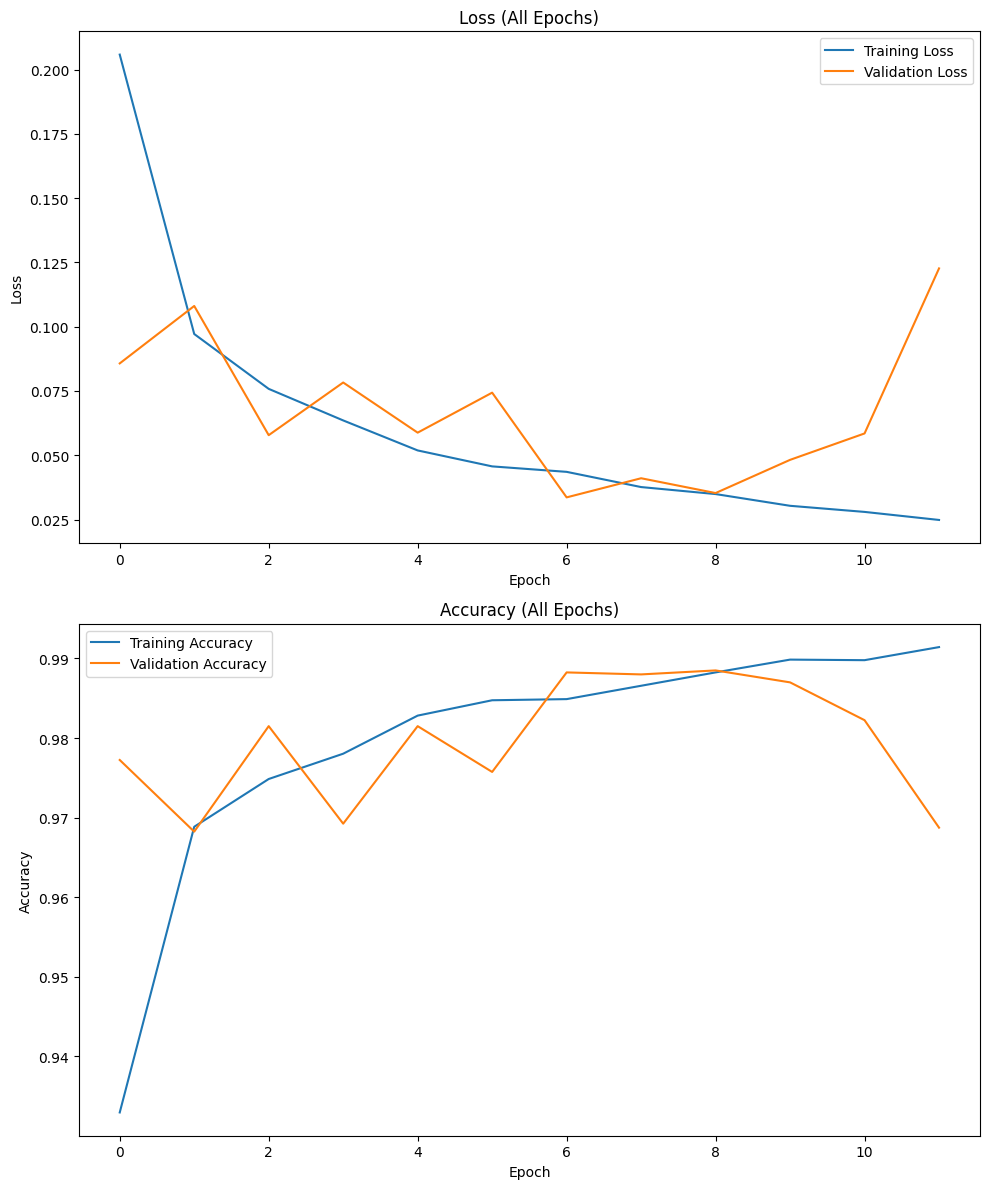

In [11]:
def plot_metrics(history):
    """
    Plot training and validation metrics.

    Args:
    - history: A history object returned by model.fit().
    """
    # Get metrics for all epochs
    train_loss_all = history.history['loss']
    val_loss_all = history.history['val_loss']
    train_accuracy_all = history.history['accuracy']
    val_accuracy_all = history.history['val_accuracy']

    # Create subplots for all metrics
    fig, axs = plt.subplots(2, figsize=(10, 12))

    # Plot training and validation loss for all epochs
    axs[0].plot(train_loss_all, label='Training Loss')
    axs[0].plot(val_loss_all, label='Validation Loss')
    axs[0].set_title('Loss (All Epochs)')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot training and validation accuracy for all epochs
    axs[1].plot(train_accuracy_all, label='Training Accuracy')
    axs[1].plot(val_accuracy_all, label='Validation Accuracy')
    axs[1].set_title('Accuracy (All Epochs)')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Adjust subplot layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call plot_metrics with the history object and the restored epoch
plot_metrics(history)

## Model Evaluation 📊🔍

In this section, we evaluate the performance of our model using various metrics and visualizations to understand its predictive capability and generalization to unseen data.

### Loss and Accuracy on Test Data
- **Loss on test data:** Loss indicates how well our model is making predictions. Lower values indicate better performance.
- **Accuracy on test data:** Accuracy represents the proportion of correct predictions made by the model over the total predictions made.

### Classification Report
The classification report provides detailed metrics about the model's performance for each class in the test data, including precision, recall, and F1-score.

### Confusion Matrix
The confusion matrix is a visual tool that allows us to evaluate the model's performance by showing the number of correct and incorrect predictions for each class.

By analyzing these metrics and visualizations, we can gain a comprehensive understanding of the model's performance and its ability to generalize to unseen data. This enables us to identify areas for improvement and make informed decisions about additional adjustments to the model if necessary.

250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 357ms/step - accuracy: 0.9870 - loss: 0.0376
Loss on test data: 0.0379319004714489
Accuracy on test data: 0.987375020980835
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 338ms/step
              precision    recall  f1-score   support

    Bacteria       0.99      0.99      0.99      1646
       Fungi       0.99      0.99      0.99      1577
     Healthy       0.98      0.99      0.98      1556
       Pests       0.98      0.99      0.98      1573
       Virus       0.99      0.99      0.99      1648

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



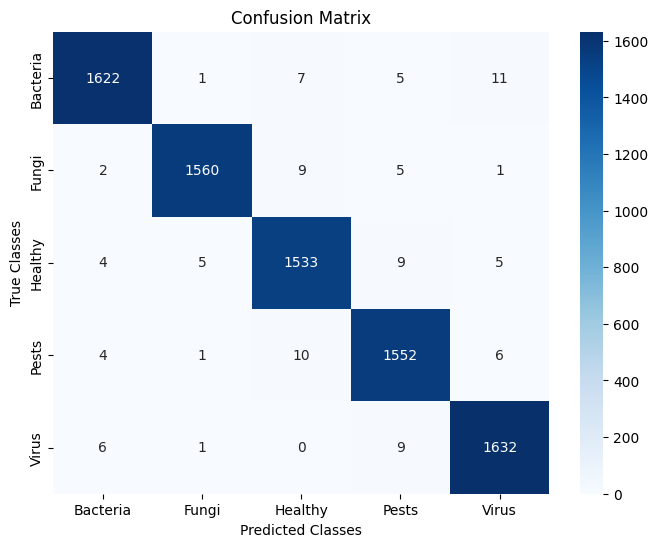

In [15]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)
print("Loss on test data:", loss)
print("Accuracy on test data:", accuracy)

# Get model predictions on the test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Get class names
class_names = test_generator.class_indices.keys()

# Generate classification report with class names
report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Print classification report with class names
print(report)

# Create a heatmap of the confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

### Model Evaluation Metrics 📊🔍

After evaluating our model on the test data, we obtain the following performance metrics:

- **Loss on test data:** 0.0379
- **Accuracy on test data:** 0.9873

These metrics indicate that our model has low loss and high accuracy in classifying test images, showcasing its robust performance.

### Classification Performance
Our model demonstrates exceptional performance in classifying images across all classes. With precision, recall, and F1-score consistently above 0.98 for each class, it excels in accurately identifying various image categories.

By achieving such high metrics, our model demonstrates its capability to effectively generalize and make accurate predictions on unseen data, making it a valuable tool for image classification tasks.

### Visualizing Predictions on Test Images
As a final step, let's visualize a subset of images from the test set along with their predicted labels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


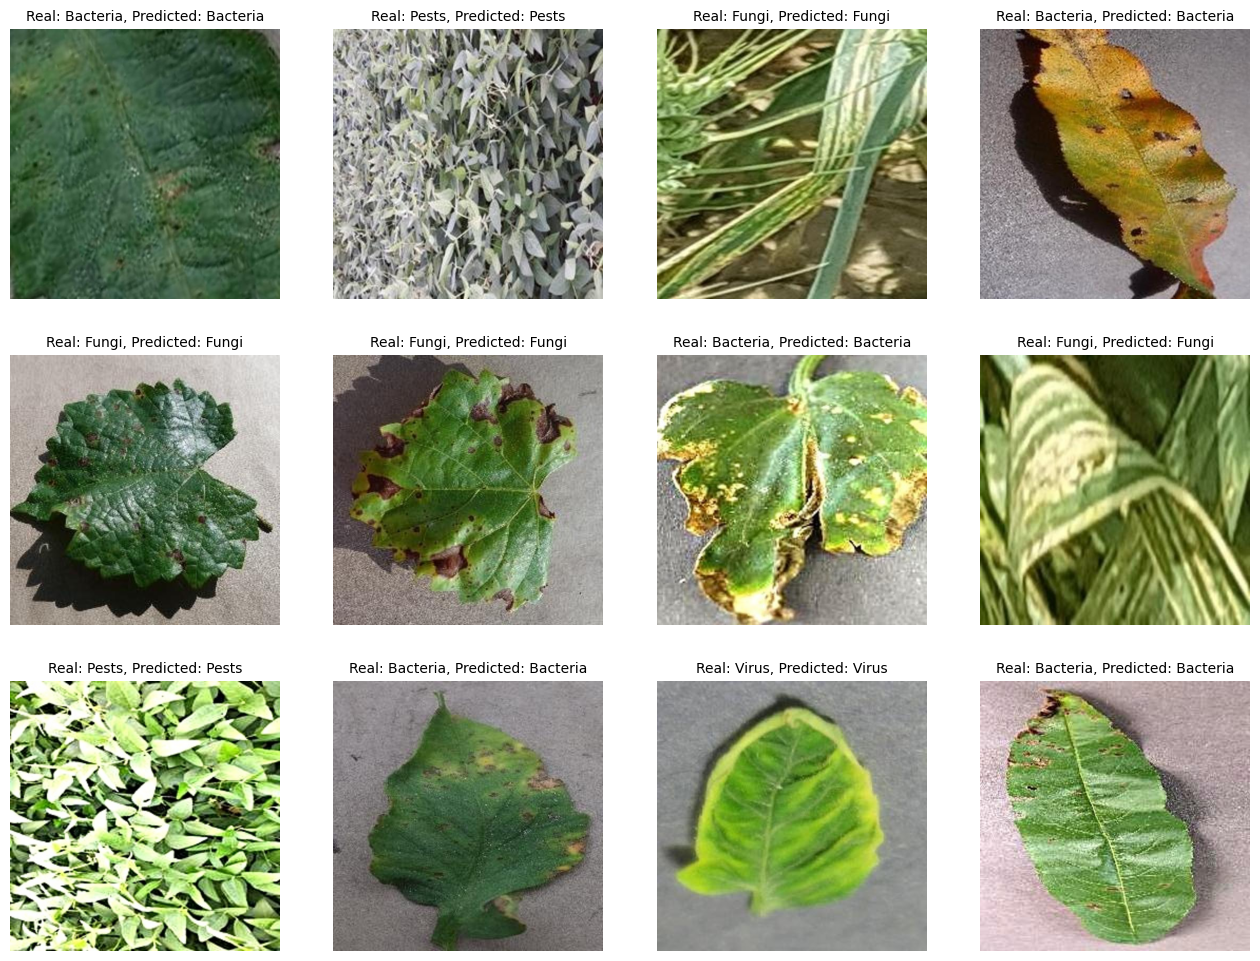

In [17]:
# Get the next batch of images from the test generator
batch = next(test_generator)
images, labels = batch

# Get predictions from the model for the batch images
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Convert class_names to a list
class_names_list = list(class_names)

# Display the first 12 images with their actual and predicted labels
plt.figure(figsize=(16, 12))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i]/255.)
    plt.title(f'Real: {class_names_list[np.argmax(labels[i])]}, Predicted: {class_names_list[predicted_labels[i]]}', fontsize=10)
    plt.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()